In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import ascii

from pyia import GaiaData
import gala.coordinates as gc

In [3]:
plt.style.use('si_lgray_ucondensed')

In [4]:
g = GaiaData('../data/gd1-with-masks.fits')
stream = g[g.pm_mask & g.gi_cmd_mask]

In [5]:
iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

In [6]:
# distance modulus
distance_app = 7.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['PS_g']-iso['PS_i']
i_g = iso['PS_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.5*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>17.8)
poly_main = poly[ind]

In [7]:
wangle = 180*u.deg
bright_mask = (g.phot_g_mean_mag<18*u.mag) & (g.phi2>-8*u.deg)

pm1_min = -9*u.mas/u.yr
pm1_max = -4.5*u.mas/u.yr
pm2_min = -1.7*u.mas/u.yr
pm2_max = 1.*u.mas/u.yr
pm_mask = g.pm_mask & (g.phi2>-8*u.deg)

phi_mask_stream = ((np.abs(g.phi2)<1*u.deg) & (g.phi1>-50*u.deg) & 
                   (g.phi1<-10*u.deg))

cmd_mask = g.gi_cmd_mask & (g.phi2>-8*u.deg)

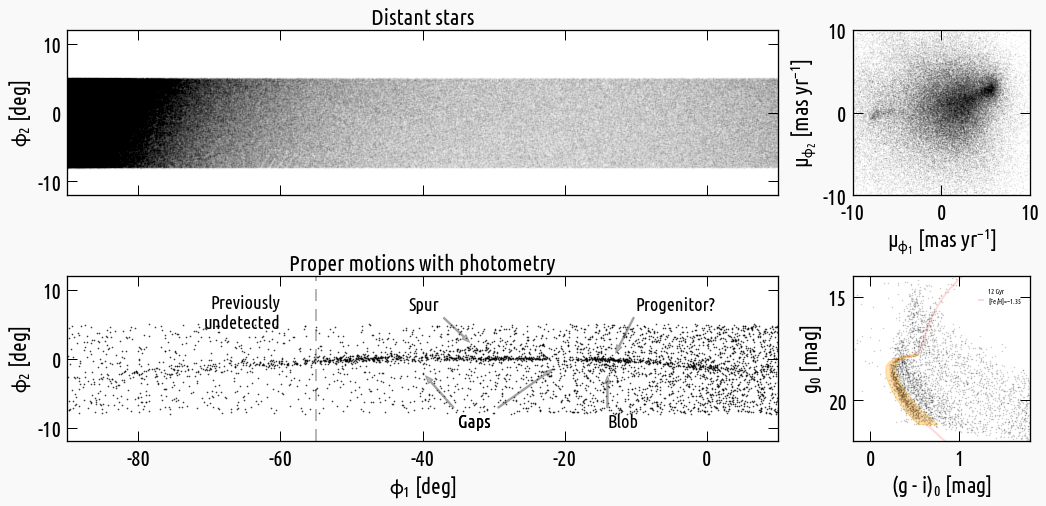

In [8]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[bright_mask], g.phi2[bright_mask], 'ko', ms=0.7, alpha=0.01, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Distant stars', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
# plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
             arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=2)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motions with photometry', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/halos/gd1_sample_0.png', dpi=133)

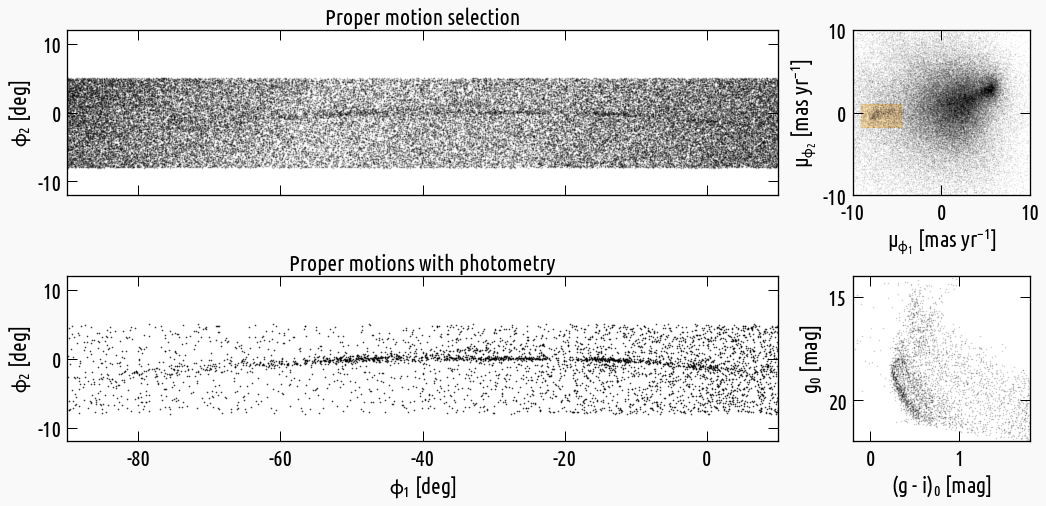

In [9]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[pm_mask], g.phi2[pm_mask], 'ko',  ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=2)
# plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motions with photometry', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
# plt.gca().add_artist(pm)

# plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/halos/gd1_sample_1.png', dpi=133)

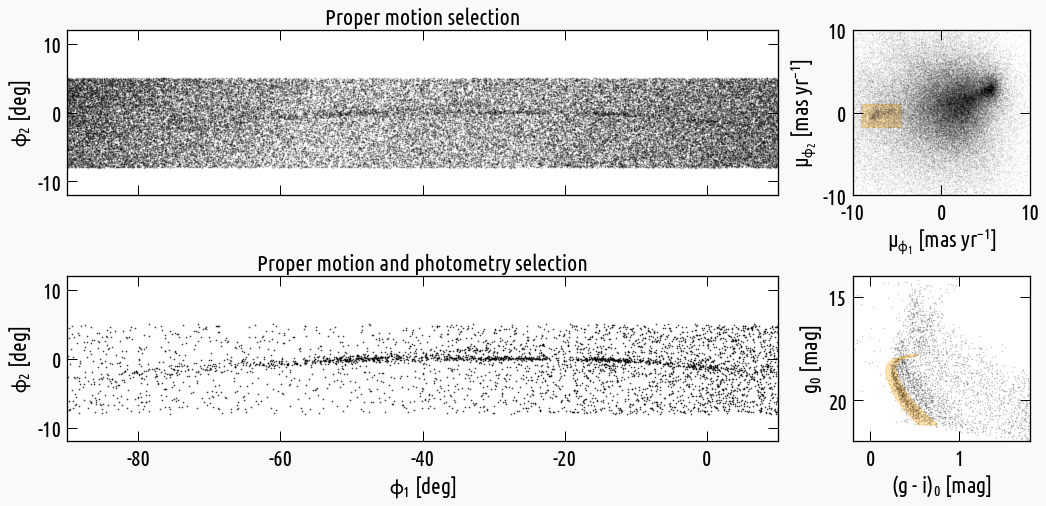

In [10]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[pm_mask], g.phi2[pm_mask], 'ko',  ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=2)
# plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion and photometry selection', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/halos/gd1_sample_2.png', dpi=133)

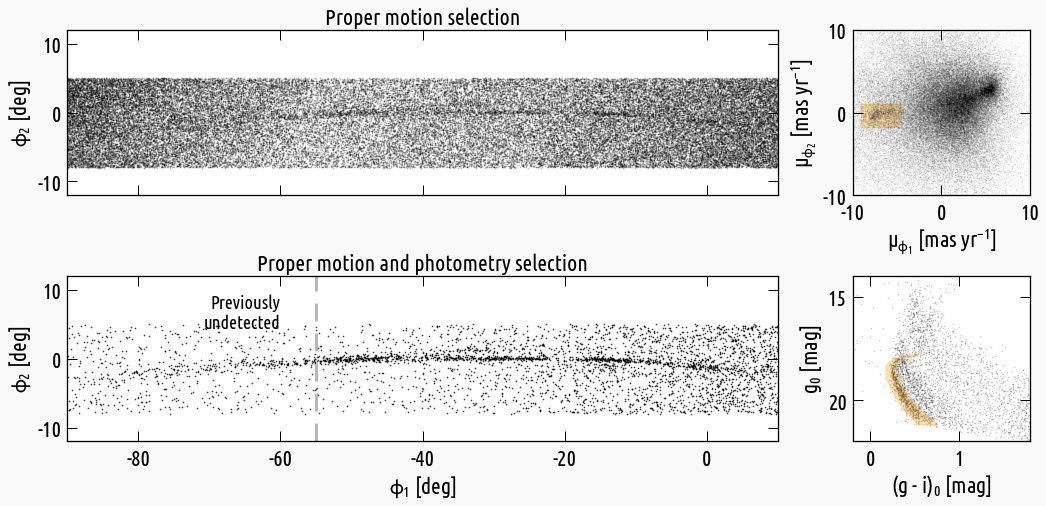

In [11]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[pm_mask], g.phi2[pm_mask], 'ko',  ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=3)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion and photometry selection', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/halos/gd1_sample_3.png', dpi=133)

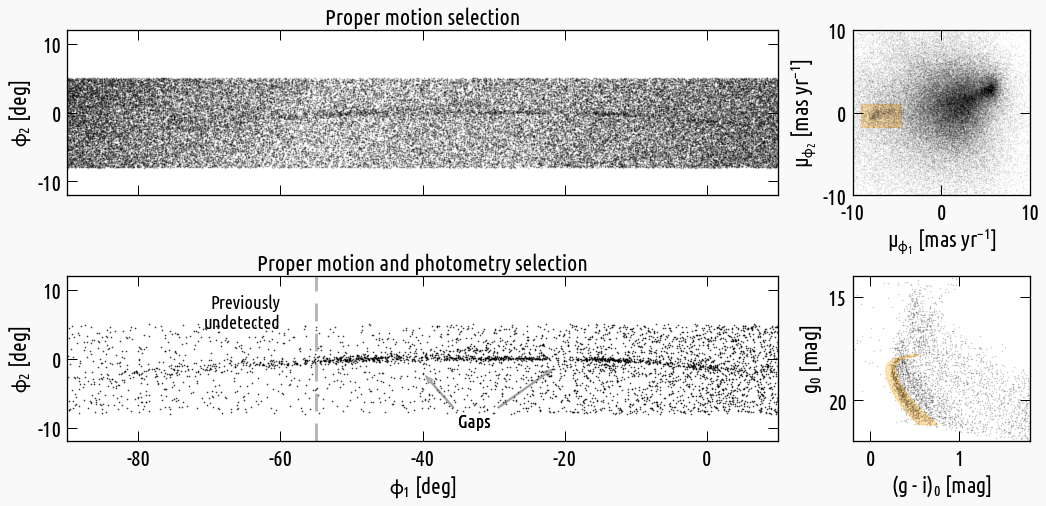

In [20]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[pm_mask], g.phi2[pm_mask], 'ko',  ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Progenitor?', xy=(-20, 1), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=3)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion and photometry selection', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/nl/gd1_sample_4.png', dpi=133)

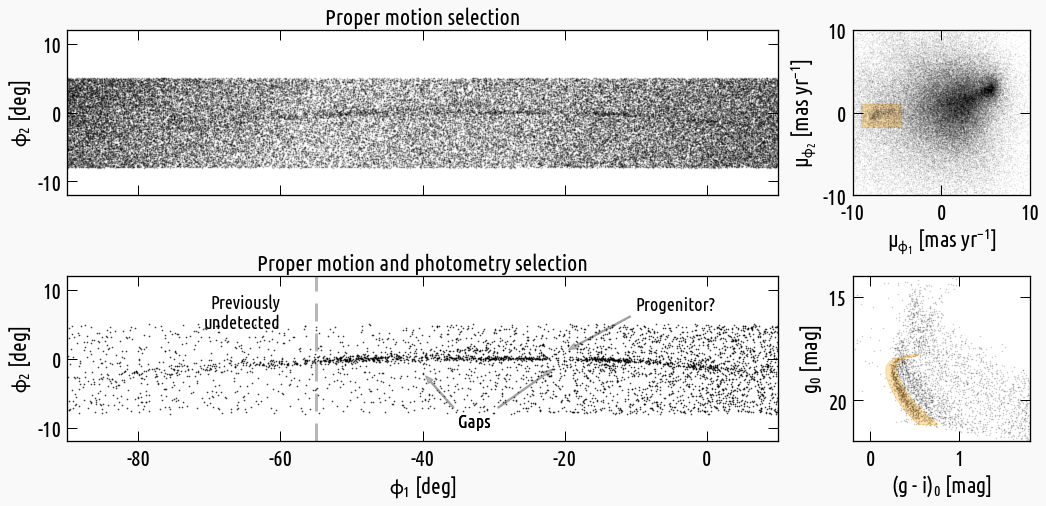

In [18]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[pm_mask], g.phi2[pm_mask], 'ko',  ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

plt.annotate('Progenitor?', xy=(-20, 1), xytext=(-10, 7),
             arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

# plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

# plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
#              arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=3)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion and photometry selection', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/nl/gd1_sample_5.png', dpi=133)

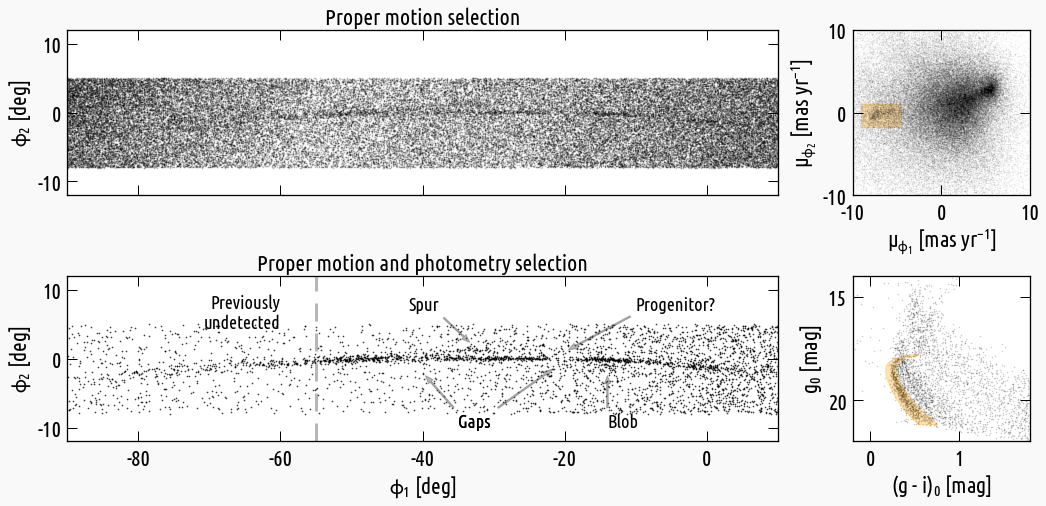

In [17]:
fig, ax = plt.subplots(2,2,figsize=(15,7.5), gridspec_kw = {'width_ratios':[4,1]})

plt.sca(ax[0][0])
plt.plot(g.phi1[pm_mask], g.phi2[pm_mask], 'ko',  ms=0.7, alpha=0.2, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.xlabel('$\phi_1$ (deg)')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[0][1])
plt.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.05, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

plt.sca(ax[1][0])
plt.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
         'ko', ms=0.7, alpha=0.7, rasterized=True)
# plt.gca().set_aspect('equal')

# plt.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
#              arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
#              fontsize='small')

plt.annotate('Progenitor?', xy=(-20, 1), xytext=(-10, 7),
             arrowprops=dict(color='0.3', shrink=0.05, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.annotate('Gaps', xy=(-21, -1), xytext=(-35, -10),
             arrowprops=dict(color='0.3', shrink=0.08, width=1.5, headwidth=6, headlength=8, alpha=0.4),
             fontsize='small')

plt.axvline(-55, ls='--', color='0.3', alpha=0.4, dashes=(6,4), lw=3)
plt.text(-60, 9.5, 'Previously\nundetected', fontsize='small', ha='right', va='top')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.title('Proper motion and photometry selection', fontsize='medium')

plt.xlim(-90,10)
plt.ylim(-12,12)

plt.sca(ax[1][1])
plt.plot(g.g[phi_mask_stream & pm_mask] - g.i[phi_mask_stream & pm_mask], g.g[phi_mask_stream & pm_mask], 
         'ko', ms=0.5, alpha=0.2, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

# plt.legend(loc=1, frameon=False, fontsize=7, handlelength=0.5, bbox_to_anchor=(0.99,0.95))
plt.xlim(-0.2, 1.8)
plt.ylim(22, 14)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('../plots/nl/gd1_sample_6.png', dpi=133)